# Class-Wise Feature Discriminability Analysis

This notebook performs class-wise feature discriminability analysis for the ESC-50 dataset. It identifies which features best separate each class from all others using statistical tests and information theory.

## Objectives

1. **Per-Class Analysis**: Identify features most relevant to each ESC-50 class
2. **Statistical Testing**: Use ANOVA F-values and mutual information to rank features
3. **Discriminative Ranking**: Rank features by discriminative power across all classes
4. **Summary Matrix**: Create comprehensive class × feature discriminability matrix
5. **Visualization**: Provide heatmaps and bar plots for interpretability

## Prerequisites

- ESC-50 dataset downloaded and extracted
- AFX library installed with all dependencies
- Statistical and information-theoretic libraries (scikit-learn, scipy.stats)


## Setup and Imports

In [1]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
import itertools

# AFX imports
sys.path.append('../')
from AFX.utils.config_loader import load_config
from AFX.io.io import load_audio
from AFX.extract_all import extract_all_features
from AFX.utils.aggregator import aggregate_features

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print('✓ All imports successful')

✓ All imports successful


## Dataset Setup and Configuration

In [2]:
# Load dataset paths from environment or use fallback
DATASET_PATH = os.getenv('ESC_50_dataset')
if DATASET_PATH is None:
    DATASET_PATH = '../data/ESC-50-master'  # Fallback path

audio_path = os.path.join(DATASET_PATH, 'audio')
metadata_path = os.path.join(DATASET_PATH, 'meta', 'esc50.csv')
config_path = os.path.join('config.json')

# Verify dataset structure
print("📁 Dataset Structure Verification:")
print(f"Audio directory: {audio_path} - {'✓ exists' if os.path.exists(audio_path) else '❌ missing'}")
print(f"Metadata file: {metadata_path} - {'✓ exists' if os.path.exists(metadata_path) else '❌ missing'}")
print(f"Config file: {config_path} - {'✓ exists' if os.path.exists(config_path) else '❌ missing'}")

# For demo purposes, we'll create synthetic data if dataset is not available
use_synthetic_data = not all([os.path.exists(audio_path), os.path.exists(metadata_path), os.path.exists(config_path)])

if use_synthetic_data:
    print("\n⚠️  Using synthetic data for demonstration (dataset not found)")
else:
    print("\n✓ Dataset structure verification passed!")

📁 Dataset Structure Verification:
Audio directory: D:\datasets\ESC-50-master\audio - ✓ exists
Metadata file: D:\datasets\ESC-50-master\meta\esc50.csv - ✓ exists
Config file: config.json - ✓ exists

✓ Dataset structure verification passed!


## Data Loading and Preparation

In [3]:
if not use_synthetic_data:
    # Load ESC-50 metadata
    try:
        metadata = pd.read_csv(metadata_path)
        print(f"✓ Successfully loaded metadata with {len(metadata)} samples")
        
        # Display dataset overview
        print(f"\n📊 Dataset Overview:")
        print(f"Total samples: {len(metadata)}")
        print(f"Number of classes: {metadata['category'].nunique()}")
        print(f"Number of folds: {metadata['fold'].nunique()}")
        
        # For computational efficiency, sample a subset
        SAMPLES_PER_CLASS = 5  # Adjust based on computational resources
        TOP_CLASSES = 10       # Focus on top N classes for demonstration
        
        # Get most frequent classes
        top_classes = metadata['category'].value_counts().head(TOP_CLASSES).index.tolist()
        print(f"\nSelected classes for analysis: {top_classes}")
        
        # Sample data from each class
        sampled_data = []
        for category in top_classes:
            class_data = metadata[metadata['category'] == category].sample(
                min(SAMPLES_PER_CLASS, len(metadata[metadata['category'] == category])), 
                random_state=42
            )
            sampled_data.append(class_data)
        
        # Combine sampled data
        sample_metadata = pd.concat(sampled_data, ignore_index=True)
        print(f"\n✓ Selected {len(sample_metadata)} samples from {len(top_classes)} classes")
        print(f"Distribution: {sample_metadata['category'].value_counts().to_dict()}")
        
    except Exception as e:
        print(f"❌ Error loading metadata: {e}")
        use_synthetic_data = True

if use_synthetic_data:
    # Create synthetic data for demonstration
    print("\n🔧 Creating synthetic data for demonstration...")
    
    # Define synthetic classes (subset of ESC-50)
    synthetic_classes = ['dog', 'cat', 'bird', 'rain', 'wind', 'fire', 'water', 'music', 'speech', 'engine']
    samples_per_class = 8
    
    # Create synthetic metadata
    synthetic_metadata = []
    for i, class_name in enumerate(synthetic_classes):
        for j in range(samples_per_class):
            synthetic_metadata.append({
                'filename': f'synthetic_{class_name}_{j:02d}.wav',
                'category': class_name,
                'fold': (j % 5) + 1,
                'target': i
            })
    
    sample_metadata = pd.DataFrame(synthetic_metadata)
    print(f"✓ Created synthetic dataset with {len(sample_metadata)} samples from {len(synthetic_classes)} classes")
    print(f"Distribution: {sample_metadata['category'].value_counts().to_dict()}")

✓ Successfully loaded metadata with 2000 samples

📊 Dataset Overview:
Total samples: 2000
Number of classes: 50
Number of folds: 5

Selected classes for analysis: ['dog', 'chirping_birds', 'vacuum_cleaner', 'thunderstorm', 'door_wood_knock', 'can_opening', 'crow', 'clapping', 'fireworks', 'chainsaw']

✓ Selected 50 samples from 10 classes
Distribution: {'dog': 5, 'chirping_birds': 5, 'vacuum_cleaner': 5, 'thunderstorm': 5, 'door_wood_knock': 5, 'can_opening': 5, 'crow': 5, 'clapping': 5, 'fireworks': 5, 'chainsaw': 5}


## Feature Extraction and Aggregation

In [4]:
if not use_synthetic_data:
    # Extract features from real audio data
    print("🔍 Extracting features from audio samples...")
    
    # Load AFX configuration
    config = load_config(config_path)
    config['preserve_shape'] = True
    config['return_metadata'] = False
    
    extracted_features = []
    labels = []
    
    for idx, row in sample_metadata.iterrows():
        filename = row['filename']
        category = row['category']
        file_path = os.path.join(audio_path, filename)
        
        try:
            # Load audio
            signal, sr = load_audio(file_path, sr=config['sample_rate'])
            
            # Extract all features
            features = extract_all_features(signal, sr, config)
            
            extracted_features.append(features)
            labels.append(category)
            
        except Exception as e:
            print(f"❌ Error processing {filename}: {e}")
            continue
    
    print(f"✓ Successfully extracted features from {len(extracted_features)} files")
    
else:
    # Create synthetic features for demonstration
    print("🔧 Creating synthetic features for demonstration...")
    
    np.random.seed(42)  # For reproducibility
    
    # Define feature names (based on common AFX features)
    feature_names = [
        'spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff',
        'mfcc_0', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5',
        'chroma_0', 'chroma_1', 'chroma_2', 'chroma_3',
        'pitch', 'hnr', 'thd', 'zcr', 'variance'
    ]
    
    extracted_features = []
    labels = []
    
    # Create class-specific feature patterns
    class_centers = {}
    for i, class_name in enumerate(synthetic_classes):
        # Each class has different characteristic features
        center = np.random.randn(len(feature_names)) * 2 + i * 0.5
        class_centers[class_name] = center
    
    for _, row in sample_metadata.iterrows():
        category = row['category']
        
        # Generate features with class-specific patterns + noise
        base_features = class_centers[category]
        noise = np.random.randn(len(feature_names)) * 0.5
        feature_values = base_features + noise
        
        # Create feature dictionary
        features = {}
        for j, feat_name in enumerate(feature_names):
            # Simulate temporal features (multiple time frames)
            temporal_length = np.random.randint(10, 50)  # Variable length
            features[feat_name] = np.random.randn(temporal_length) * 0.2 + feature_values[j]
        
        extracted_features.append(features)
        labels.append(category)
    
    print(f"✓ Generated synthetic features for {len(extracted_features)} samples")
    print(f"Feature names: {feature_names}")

🔍 Extracting features from audio samples...
✓ Successfully extracted features from 50 files


In [5]:
# Apply aggregation methods to get fixed-size feature vectors
print("📊 Applying feature aggregation...")

# Test different aggregation methods
aggregation_methods = ['mean', 'std', 'summary']
aggregated_datasets = {}

for method in aggregation_methods:
    print(f"\nApplying {method} aggregation...")
    method_results = []
    
    for features in extracted_features:
        try:
            agg_result = aggregate_features(features, method=method, flatten=True)
            method_results.append(agg_result)
        except Exception as e:
            print(f"❌ Error in {method} aggregation: {e}")
            continue
    
    aggregated_datasets[method] = method_results
    
    if method_results:
        total_features = sum(len(result) for result in method_results) // len(method_results)
        print(f"✓ {method} aggregation completed: {len(method_results)} samples, {total_features} features per sample")

# Use 'mean' aggregation as primary dataset for analysis
mean_aggregated = aggregated_datasets.get('mean', [])

if mean_aggregated:
    print(f"\n✓ Using mean aggregation for discriminability analysis")
    print(f"Dataset: {len(mean_aggregated)} samples")
    print(f"Features per sample: {len(mean_aggregated[0])}")
    print(f"Feature names (first 10): {list(mean_aggregated[0].keys())[:10]}")
else:
    print("❌ No aggregated features available for analysis")
    sys.exit(1)

📊 Applying feature aggregation...

Applying mean aggregation...
✓ mean aggregation completed: 50 samples, 16 features per sample

Applying std aggregation...
✓ std aggregation completed: 50 samples, 16 features per sample

Applying summary aggregation...
✓ summary aggregation completed: 50 samples, 32 features per sample

✓ Using mean aggregation for discriminability analysis
Dataset: 50 samples
Features per sample: 16
Feature names (first 10): ['zcr', 'variance', 'rms_energy', 'spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'spectral_skewness', 'spectral_slope', 'melspectrogram', 'mfcc']


## Class-Wise Feature Discriminability Analysis

In [6]:
# Prepare data matrices for statistical analysis
print("🔧 Preparing data matrices for analysis...")

# Convert aggregated features to matrix format
feature_names = list(mean_aggregated[0].keys())
n_samples = len(mean_aggregated)
n_features = len(feature_names)

# Create feature matrix (samples x features)
X = np.zeros((n_samples, n_features))
for i, features in enumerate(mean_aggregated):
    for j, feat_name in enumerate(feature_names):
        # Handle both scalar and array features
        feat_value = features[feat_name]
        if isinstance(feat_value, np.ndarray):
            X[i, j] = feat_value.mean() if feat_value.size > 0 else 0.0
        else:
            X[i, j] = feat_value

# Create label vector
y = np.array(labels)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Get unique classes
unique_classes = label_encoder.classes_
n_classes = len(unique_classes)

print(f"✓ Data matrix prepared:")
print(f"  Shape: {X.shape} (samples x features)")
print(f"  Classes: {n_classes} ({unique_classes})")
print(f"  Features: {n_features}")
print(f"  Class distribution: {dict(zip(*np.unique(y, return_counts=True)))}")

🔧 Preparing data matrices for analysis...
✓ Data matrix prepared:
  Shape: (50, 16) (samples x features)
  Classes: 10 (['can_opening' 'chainsaw' 'chirping_birds' 'clapping' 'crow' 'dog'
 'door_wood_knock' 'fireworks' 'thunderstorm' 'vacuum_cleaner'])
  Features: 16
  Class distribution: {np.str_('can_opening'): np.int64(5), np.str_('chainsaw'): np.int64(5), np.str_('chirping_birds'): np.int64(5), np.str_('clapping'): np.int64(5), np.str_('crow'): np.int64(5), np.str_('dog'): np.int64(5), np.str_('door_wood_knock'): np.int64(5), np.str_('fireworks'): np.int64(5), np.str_('thunderstorm'): np.int64(5), np.str_('vacuum_cleaner'): np.int64(5)}


In [7]:
# Compute ANOVA F-values for each feature across all classes
print("📈 Computing ANOVA F-values for feature discriminability...")

anova_results = {}

for j, feat_name in enumerate(feature_names):
    # Extract feature values for all classes
    class_groups = []
    for class_idx in range(n_classes):
        class_mask = y_encoded == class_idx
        class_feature_values = X[class_mask, j]
        if len(class_feature_values) > 0:
            class_groups.append(class_feature_values)
    
    # Perform ANOVA test
    if len(class_groups) >= 2 and all(len(group) > 0 for group in class_groups):
        try:
            f_stat, p_value = f_oneway(*class_groups)
            anova_results[feat_name] = {
                'f_statistic': f_stat,
                'p_value': p_value,
                'significant': p_value < 0.05
            }
        except Exception as e:
            print(f"Warning: ANOVA failed for {feat_name}: {e}")
            anova_results[feat_name] = {
                'f_statistic': 0.0,
                'p_value': 1.0,
                'significant': False
            }
    else:
        anova_results[feat_name] = {
            'f_statistic': 0.0,
            'p_value': 1.0,
            'significant': False
        }

# Sort features by F-statistic
sorted_by_anova = sorted(anova_results.items(), 
                        key=lambda x: x[1]['f_statistic'], 
                        reverse=True)

print(f"\n🏆 Top 10 Features by ANOVA F-statistic:")
for i, (feat_name, results) in enumerate(sorted_by_anova[:10]):
    significance = "***" if results['significant'] else ""
    print(f"  {i+1:2d}. {feat_name:20s}: F={results['f_statistic']:8.4f}, p={results['p_value']:.4f} {significance}")

print(f"\nSignificant features (p < 0.05): {sum(1 for _, r in anova_results.items() if r['significant'])} / {len(anova_results)}")

📈 Computing ANOVA F-values for feature discriminability...

🏆 Top 10 Features by ANOVA F-statistic:
   1. gfcc                : F= 14.7410, p=0.0000 ***
   2. spectral_centroid   : F= 12.3529, p=0.0000 ***
   3. spectral_skewness   : F= 11.7504, p=0.0000 ***
   4. spectral_slope      : F= 10.7757, p=0.0000 ***
   5. zcr                 : F= 10.5228, p=0.0000 ***
   6. mfcc                : F= 10.0384, p=0.0000 ***
   7. spectral_bandwidth  : F=  9.4082, p=0.0000 ***
   8. spectral_rolloff    : F=  9.3559, p=0.0000 ***
   9. pitch               : F=  8.8225, p=0.0000 ***
  10. mfcc_delta          : F=  5.7605, p=0.0000 ***

Significant features (p < 0.05): 15 / 16


In [8]:
# Compute mutual information between features and class labels
print("🔍 Computing mutual information scores...")

try:
    # Handle any NaN or infinite values
    X_clean = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Compute mutual information
    mi_scores = mutual_info_classif(X_clean, y_encoded, random_state=42)
    
    # Create mutual information results dictionary
    mi_results = {}
    for j, feat_name in enumerate(feature_names):
        mi_results[feat_name] = mi_scores[j]
    
    # Sort features by mutual information
    sorted_by_mi = sorted(mi_results.items(), key=lambda x: x[1], reverse=True)
    
    print(f"\n🏆 Top 10 Features by Mutual Information:")
    for i, (feat_name, score) in enumerate(sorted_by_mi[:10]):
        print(f"  {i+1:2d}. {feat_name:20s}: MI={score:.6f}")
    
    print(f"\nMutual information statistics:")
    print(f"  Mean MI: {np.mean(mi_scores):.6f}")
    print(f"  Max MI:  {np.max(mi_scores):.6f}")
    print(f"  Min MI:  {np.min(mi_scores):.6f}")
    
except Exception as e:
    print(f"❌ Error computing mutual information: {e}")
    # Create dummy results
    mi_results = {feat_name: 0.0 for feat_name in feature_names}
    sorted_by_mi = list(mi_results.items())

🔍 Computing mutual information scores...

🏆 Top 10 Features by Mutual Information:
   1. chroma_cqt          : MI=1.559090
   2. zcr                 : MI=0.814796
   3. spectral_centroid   : MI=0.790657
   4. spectral_skewness   : MI=0.735595
   5. gfcc                : MI=0.729765
   6. spectral_rolloff    : MI=0.718051
   7. pitch               : MI=0.664472
   8. mfcc                : MI=0.614359
   9. spectral_bandwidth  : MI=0.569784
  10. spectral_slope      : MI=0.540119

Mutual information statistics:
  Mean MI: 0.624141
  Max MI:  1.559090
  Min MI:  0.185704


In [9]:
# Perform per-class discriminability analysis
print("🎯 Computing per-class feature discriminability...")

# For each class, compute how well each feature separates that class from all others
class_discriminability = {}

for class_idx, class_name in enumerate(unique_classes):
    print(f"\nAnalyzing class: {class_name}")
    
    # Create binary labels (current class vs all others)
    binary_labels = (y_encoded == class_idx).astype(int)
    
    class_results = {}
    
    for j, feat_name in enumerate(feature_names):
        # Extract feature values
        feature_values = X[:, j]
        
        # Compute class-conditional statistics
        class_mask = binary_labels == 1
        other_mask = binary_labels == 0
        
        class_values = feature_values[class_mask]
        other_values = feature_values[other_mask]
        
        if len(class_values) > 0 and len(other_values) > 0:
            # Compute statistics
            class_mean = np.mean(class_values)
            class_std = np.std(class_values)
            other_mean = np.mean(other_values)
            other_std = np.std(other_values)
            
            # Compute separability metrics
            mean_difference = abs(class_mean - other_mean)
            pooled_std = np.sqrt((class_std**2 + other_std**2) / 2)
            
            # Effect size (Cohen's d)
            cohens_d = mean_difference / pooled_std if pooled_std > 0 else 0.0
            
            # Variance ratio (between-class vs within-class)
            between_var = mean_difference**2
            within_var = (class_std**2 + other_std**2) / 2
            var_ratio = between_var / within_var if within_var > 0 else 0.0
            
            # T-test for this feature between class and others
            try:
                t_stat, t_p = stats.ttest_ind(class_values, other_values)
                t_stat = abs(t_stat)  # Use absolute value
            except:
                t_stat, t_p = 0.0, 1.0
            
            class_results[feat_name] = {
                'class_mean': class_mean,
                'class_std': class_std,
                'other_mean': other_mean,
                'other_std': other_std,
                'mean_difference': mean_difference,
                'cohens_d': cohens_d,
                'variance_ratio': var_ratio,
                't_statistic': t_stat,
                't_p_value': t_p
            }
        else:
            # Handle edge case with no data
            class_results[feat_name] = {
                'class_mean': 0.0,
                'class_std': 0.0,
                'other_mean': 0.0,
                'other_std': 0.0,
                'mean_difference': 0.0,
                'cohens_d': 0.0,
                'variance_ratio': 0.0,
                't_statistic': 0.0,
                't_p_value': 1.0
            }
    
    class_discriminability[class_name] = class_results

print(f"\n✓ Completed per-class analysis for {len(unique_classes)} classes")

🎯 Computing per-class feature discriminability...

Analyzing class: can_opening

Analyzing class: chainsaw

Analyzing class: chirping_birds

Analyzing class: clapping

Analyzing class: crow

Analyzing class: dog

Analyzing class: door_wood_knock

Analyzing class: fireworks

Analyzing class: thunderstorm

Analyzing class: vacuum_cleaner

✓ Completed per-class analysis for 10 classes


## Summary Matrix Creation

In [10]:
# Create comprehensive discriminability summary matrix
print("📋 Creating discriminability summary matrix...")

# Choose discriminability metric (we'll use Cohen's d as primary metric)
discriminability_metric = 'cohens_d'

# Create matrix: rows = classes, columns = features
summary_matrix = np.zeros((n_classes, n_features))
feature_rankings = {}

for i, class_name in enumerate(unique_classes):
    class_scores = []
    for j, feat_name in enumerate(feature_names):
        score = class_discriminability[class_name][feat_name][discriminability_metric]
        summary_matrix[i, j] = score
        class_scores.append((feat_name, score))
    
    # Sort features by discriminability for this class
    class_scores.sort(key=lambda x: x[1], reverse=True)
    feature_rankings[class_name] = class_scores

# Create DataFrame for easier manipulation
summary_df = pd.DataFrame(summary_matrix, 
                         index=unique_classes, 
                         columns=feature_names)

print(f"✓ Summary matrix created: {summary_matrix.shape} (classes x features)")
print(f"\nMatrix statistics:")
print(f"  Mean discriminability: {np.mean(summary_matrix):.4f}")
print(f"  Max discriminability:  {np.max(summary_matrix):.4f}")
print(f"  Min discriminability:  {np.min(summary_matrix):.4f}")

# Display top features for each class
print(f"\n🏆 Top 5 Features per Class (by {discriminability_metric}):")
for class_name in unique_classes:
    top_features = feature_rankings[class_name][:5]
    feature_list = [f"{feat}({score:.3f})" for feat, score in top_features]
    print(f"  {class_name:12s}: {', '.join(feature_list)}")

📋 Creating discriminability summary matrix...
✓ Summary matrix created: (10, 16) (classes x features)

Matrix statistics:
  Mean discriminability: 0.8400
  Max discriminability:  3.4928
  Min discriminability:  0.0043

🏆 Top 5 Features per Class (by cohens_d):
  can_opening : spectral_slope(2.769), spectral_rolloff(2.115), spectral_centroid(2.035), zcr(1.854), mfcc(1.758)
  chainsaw    : gfcc(1.658), mfcc(1.648), rms_energy(1.172), spectral_bandwidth(1.170), pitch(0.873)
  chirping_birds: thd(1.559), hnr(1.298), spectral_bandwidth(1.179), rms_energy(1.071), melspectrogram(0.866)
  clapping    : hnr(1.264), gfcc(0.953), spectral_bandwidth(0.858), pitch(0.850), spectral_skewness(0.600)
  crow        : spectral_bandwidth(0.829), pitch(0.633), chroma_cqt(0.570), spectral_slope(0.456), mfcc_delta(0.391)
  dog         : spectral_centroid(0.970), spectral_skewness(0.785), spectral_rolloff(0.762), zcr(0.674), spectral_slope(0.647)
  door_wood_knock: gfcc(3.493), spectral_skewness(3.455), mfcc_

## Visualizations

🎨 Creating visualization plots...


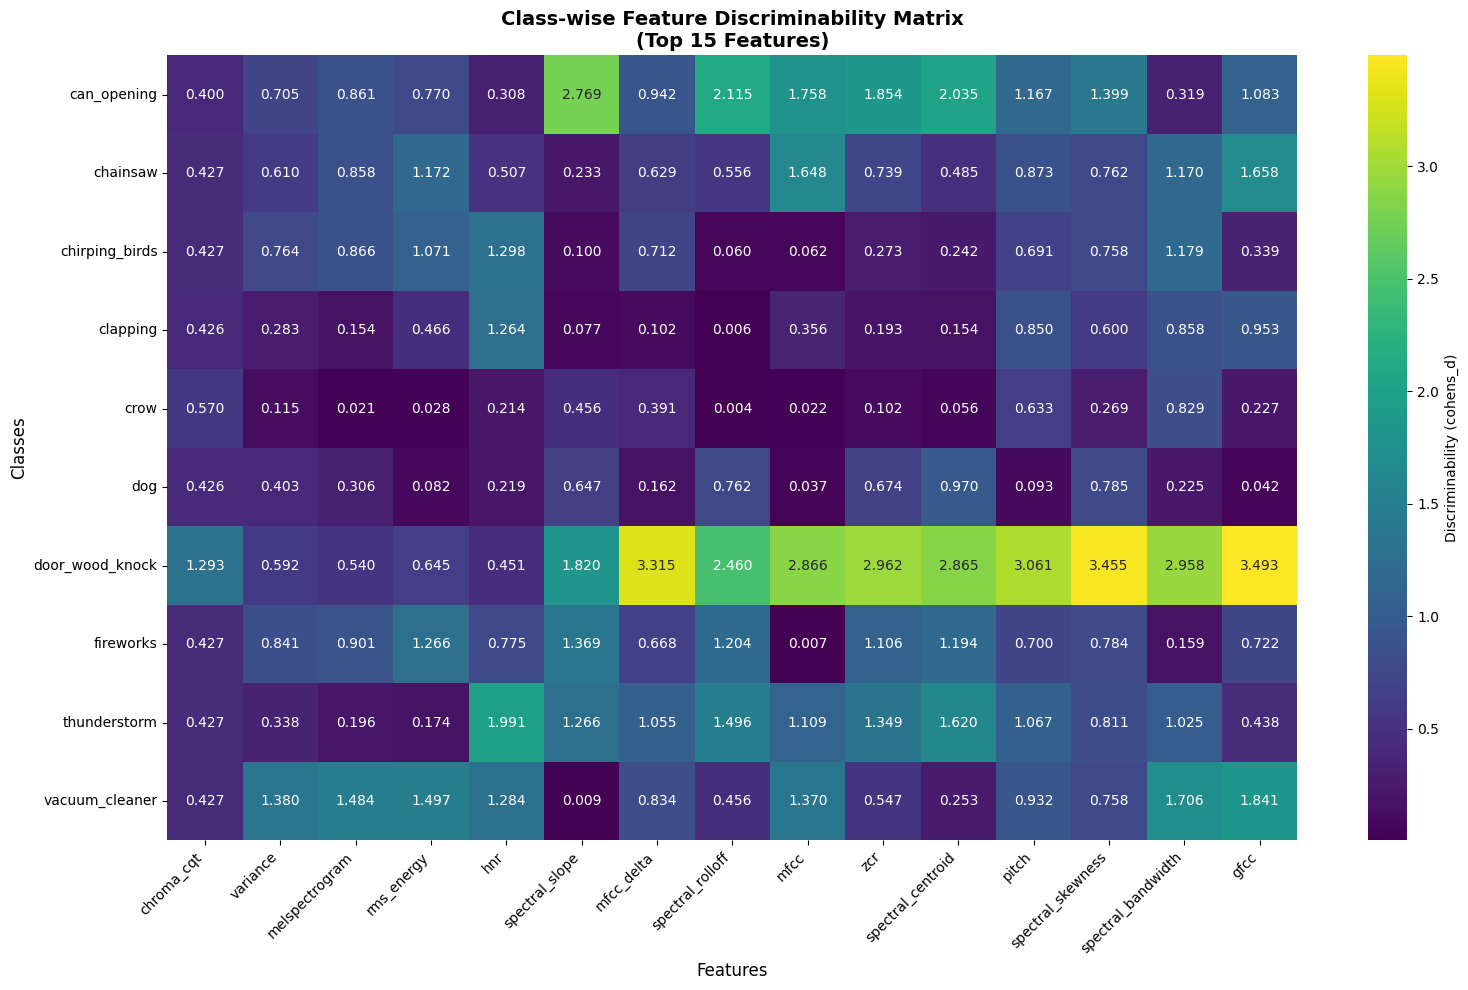

✓ Discriminability matrix heatmap created


In [11]:
# Create comprehensive heatmap visualizations
print("🎨 Creating visualization plots...")

# 1. Summary matrix heatmap
plt.figure(figsize=(16, 10))

# Use top features for better readability
top_n_features = 15
feature_importance = np.mean(summary_matrix, axis=0)
top_feature_indices = np.argsort(feature_importance)[-top_n_features:]
top_feature_names = [feature_names[i] for i in top_feature_indices]

# Create subset matrix for visualization
subset_matrix = summary_matrix[:, top_feature_indices]

# Create heatmap
sns.heatmap(subset_matrix, 
            xticklabels=top_feature_names,
            yticklabels=unique_classes,
            annot=True, fmt='.3f', 
            cmap='viridis', 
            cbar_kws={'label': f'Discriminability ({discriminability_metric})'})

plt.title(f'Class-wise Feature Discriminability Matrix\n(Top {top_n_features} Features)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Classes', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("✓ Discriminability matrix heatmap created")

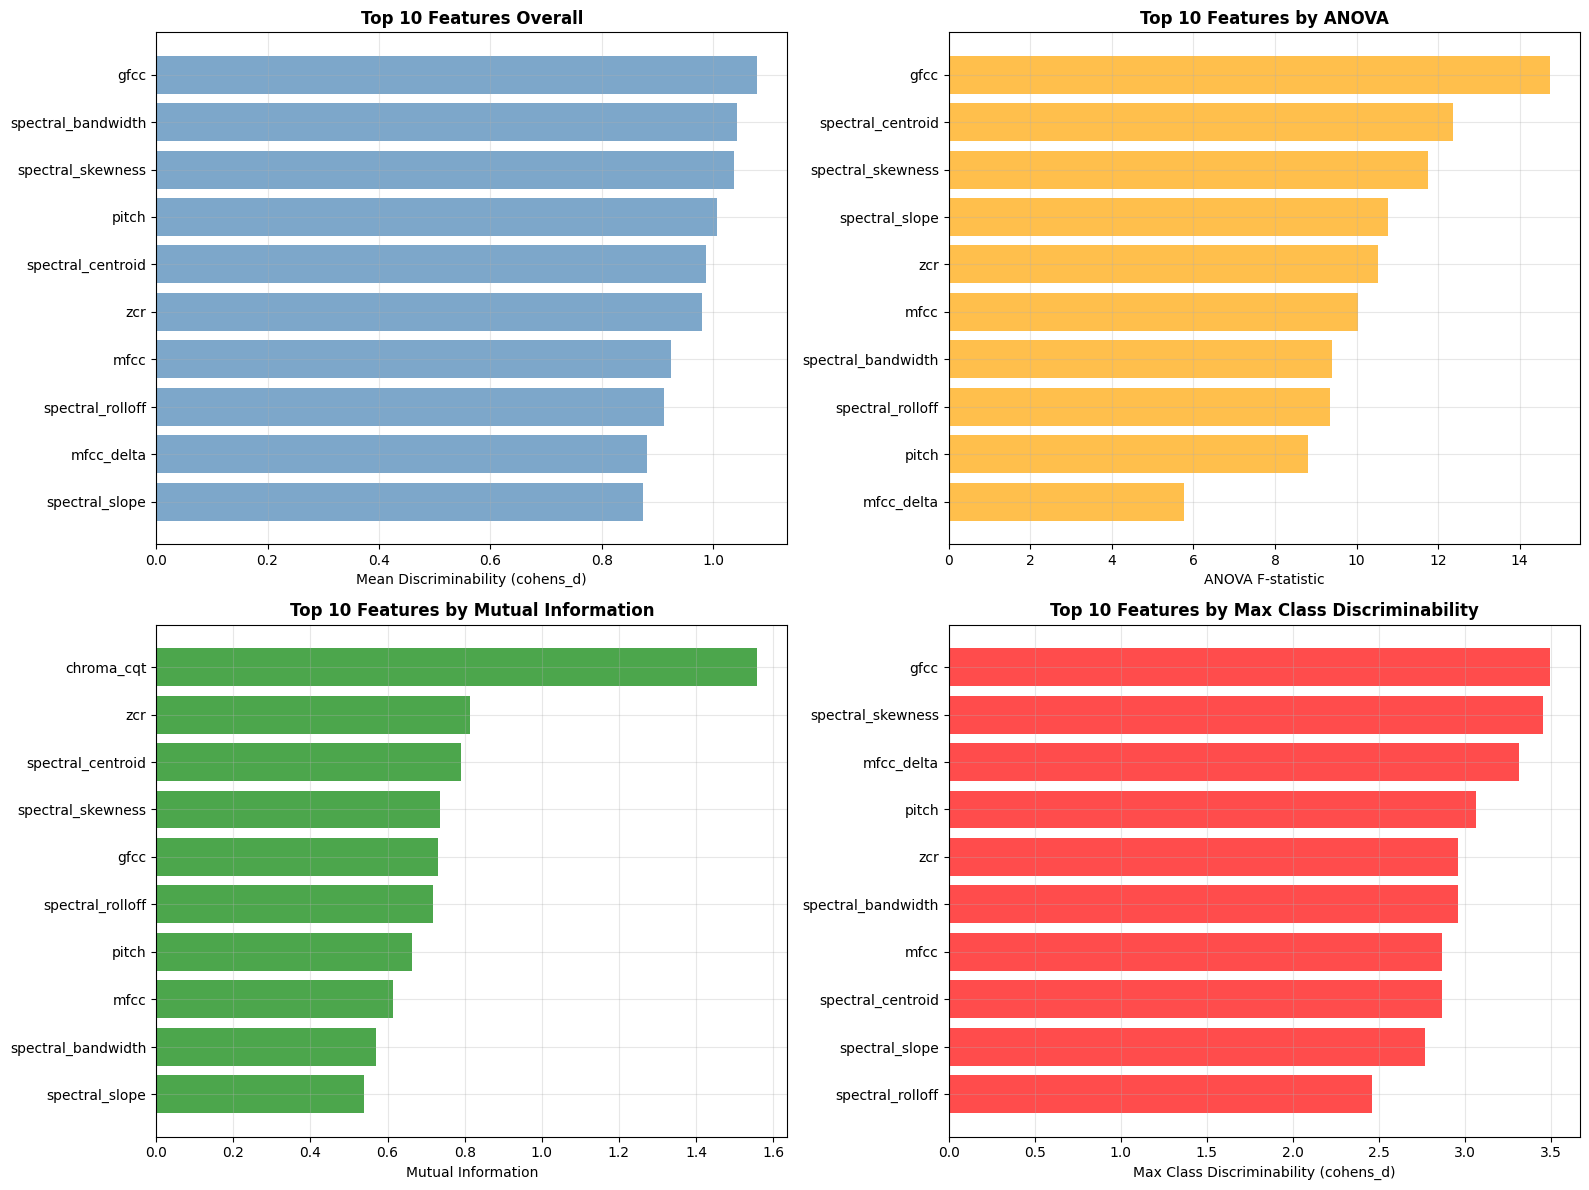

✓ Feature ranking plots created


In [12]:
# Create feature ranking bar plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

# Plot 1: Overall feature importance (mean across classes)
ax = axes[0]
overall_importance = np.mean(summary_matrix, axis=0)
sorted_indices = np.argsort(overall_importance)[-10:]  # Top 10
top_features = [feature_names[i] for i in sorted_indices]
top_scores = [overall_importance[i] for i in sorted_indices]

ax.barh(range(len(top_features)), top_scores, color='steelblue', alpha=0.7)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features)
ax.set_xlabel(f'Mean Discriminability ({discriminability_metric})')
ax.set_title('Top 10 Features Overall', fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 2: ANOVA F-statistics
ax = axes[1]
anova_scores = [anova_results[feat]['f_statistic'] for feat in feature_names]
sorted_indices = np.argsort(anova_scores)[-10:]
top_features = [feature_names[i] for i in sorted_indices]
top_scores = [anova_scores[i] for i in sorted_indices]

ax.barh(range(len(top_features)), top_scores, color='orange', alpha=0.7)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features)
ax.set_xlabel('ANOVA F-statistic')
ax.set_title('Top 10 Features by ANOVA', fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 3: Mutual Information scores
ax = axes[2]
mi_scores_list = [mi_results[feat] for feat in feature_names]
sorted_indices = np.argsort(mi_scores_list)[-10:]
top_features = [feature_names[i] for i in sorted_indices]
top_scores = [mi_scores_list[i] for i in sorted_indices]

ax.barh(range(len(top_features)), top_scores, color='green', alpha=0.7)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features)
ax.set_xlabel('Mutual Information')
ax.set_title('Top 10 Features by Mutual Information', fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 4: Class-specific variance (max discriminability per feature)
ax = axes[3]
max_class_scores = np.max(summary_matrix, axis=0)
sorted_indices = np.argsort(max_class_scores)[-10:]
top_features = [feature_names[i] for i in sorted_indices]
top_scores = [max_class_scores[i] for i in sorted_indices]

ax.barh(range(len(top_features)), top_scores, color='red', alpha=0.7)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features)
ax.set_xlabel(f'Max Class Discriminability ({discriminability_metric})')
ax.set_title('Top 10 Features by Max Class Discriminability', fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Feature ranking plots created")

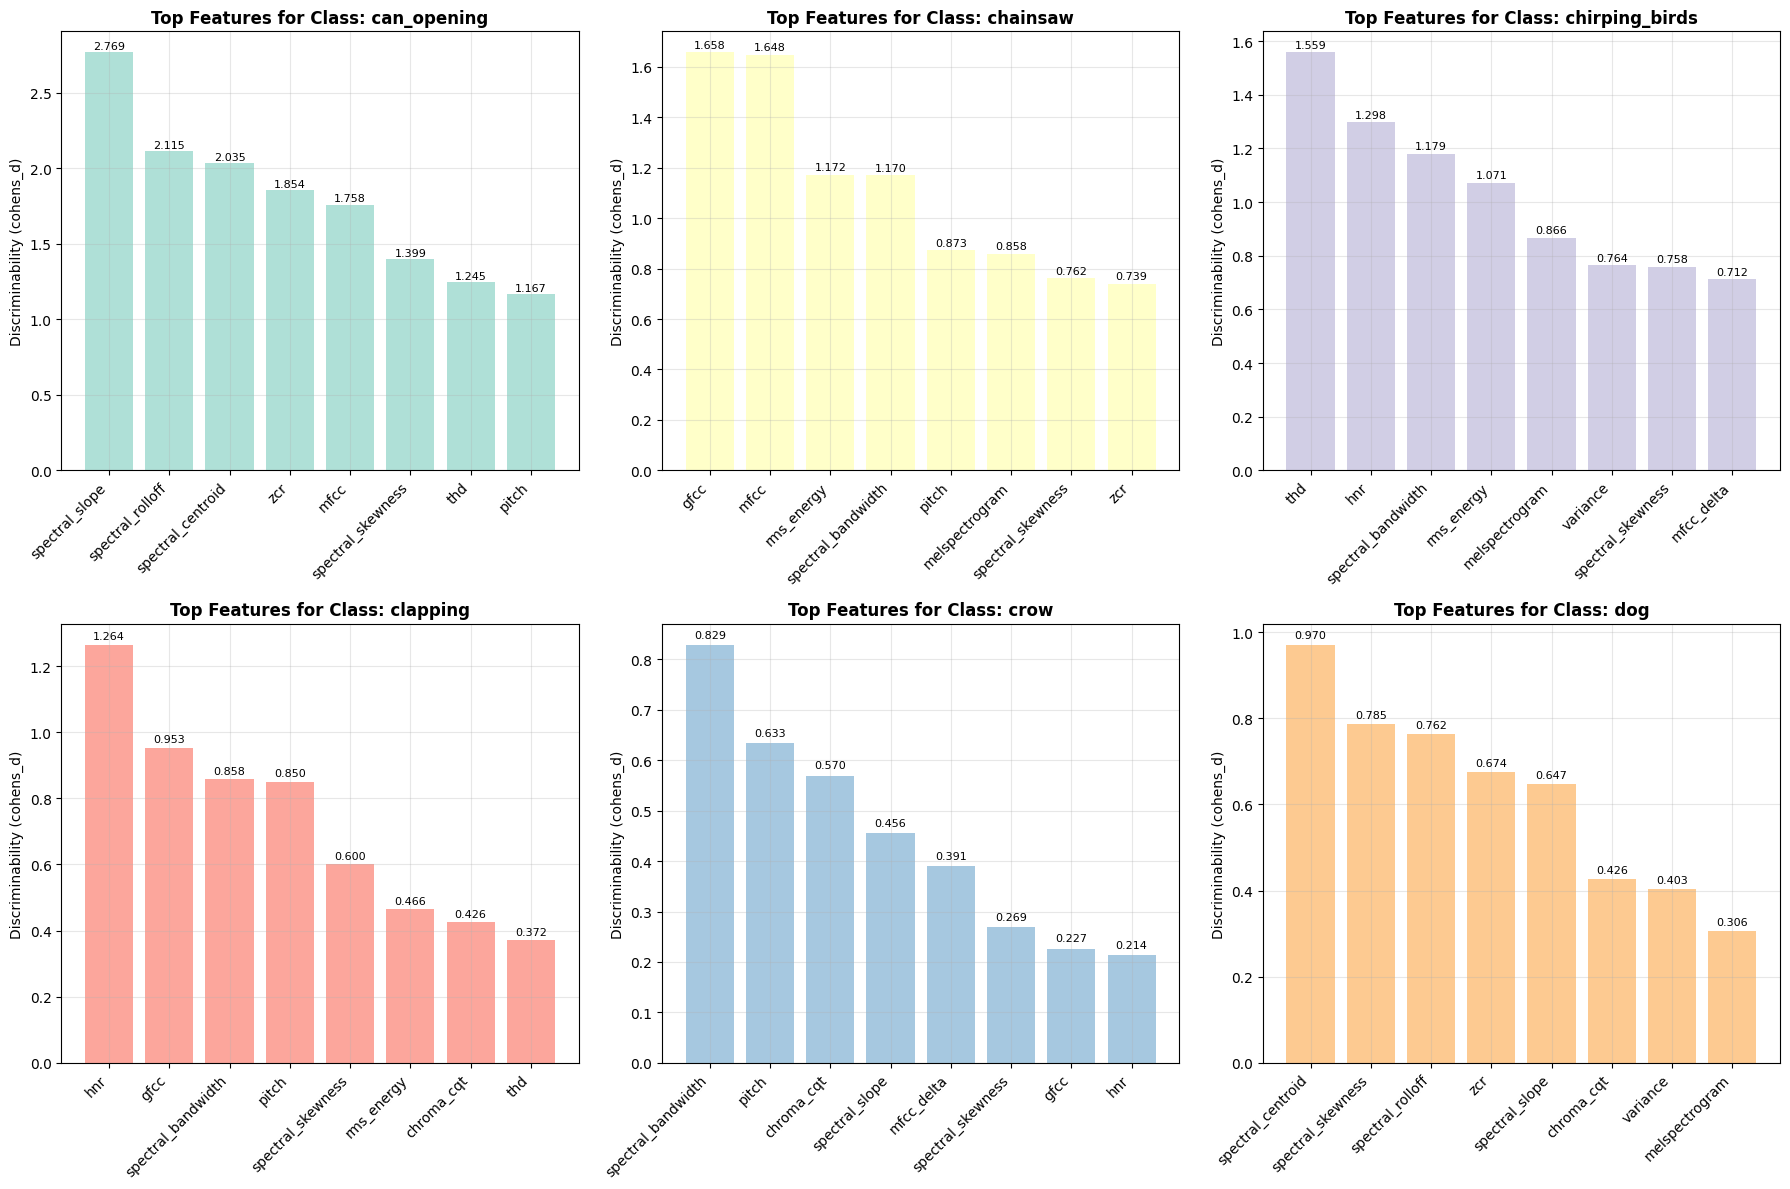

✓ Class-specific discriminability plots created for 6 classes


In [13]:
# Create class-specific feature discriminability plots
n_classes_to_show = min(6, len(unique_classes))  # Show up to 6 classes
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, class_name in enumerate(unique_classes[:n_classes_to_show]):
    ax = axes[i]
    
    # Get top features for this class
    class_scores = feature_rankings[class_name][:8]  # Top 8 features
    features = [feat for feat, _ in class_scores]
    scores = [score for _, score in class_scores]
    
    # Create bar plot
    bars = ax.bar(range(len(features)), scores, 
                  color=plt.cm.Set3(i), alpha=0.7)
    
    ax.set_xticks(range(len(features)))
    ax.set_xticklabels(features, rotation=45, ha='right')
    ax.set_ylabel(f'Discriminability ({discriminability_metric})')
    ax.set_title(f'Top Features for Class: {class_name}', fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, score in zip(bars, scores):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{score:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print(f"✓ Class-specific discriminability plots created for {n_classes_to_show} classes")

## Analysis Summary and Insights

In [14]:
# Provide comprehensive analysis summary
print("📝 COMPREHENSIVE ANALYSIS SUMMARY")
print("="*60)

# 1. Overall feature ranking comparison
print("\n🏆 TOP DISCRIMINATIVE FEATURES ACROSS METHODS:")
print("-"*50)

# Get top 5 from each method
top_overall = [feat for feat, _ in sorted([(feat, np.mean(summary_matrix[:, i])) 
                                          for i, feat in enumerate(feature_names)], 
                                         key=lambda x: x[1], reverse=True)[:5]]

top_anova = [feat for feat, _ in sorted_by_anova[:5]]
top_mi = [feat for feat, _ in sorted_by_mi[:5]]

print(f"By Class Discriminability: {', '.join(top_overall)}")
print(f"By ANOVA F-statistic:     {', '.join(top_anova)}")
print(f"By Mutual Information:     {', '.join(top_mi)}")

# Find consensus features
all_top_features = set(top_overall + top_anova + top_mi)
consensus_features = []
for feat in all_top_features:
    count = sum([feat in top_overall, feat in top_anova, feat in top_mi])
    if count >= 2:
        consensus_features.append(feat)

print(f"\n🎯 CONSENSUS TOP FEATURES (appearing in 2+ methods): {', '.join(consensus_features)}")

# 2. Class-specific insights
print("\n\n🔍 CLASS-SPECIFIC INSIGHTS:")
print("-"*50)

for class_name in unique_classes:
    top_class_features = [feat for feat, _ in feature_rankings[class_name][:3]]
    # Find class samples
    class_count = sum(1 for label in labels if label == class_name)
    print(f"{class_name:12s} ({class_count:2d} samples): {', '.join(top_class_features)}")

# 3. Feature category analysis
print("\n\n📊 FEATURE CATEGORY ANALYSIS:")
print("-"*50)

# Group features by type (basic heuristic)
feature_categories = {
    'spectral': [f for f in feature_names if any(x in f.lower() for x in ['spectral', 'centroid', 'bandwidth', 'rolloff'])],
    'mfcc': [f for f in feature_names if 'mfcc' in f.lower()],
    'chroma': [f for f in feature_names if 'chroma' in f.lower()],
    'harmonic': [f for f in feature_names if any(x in f.lower() for x in ['pitch', 'hnr', 'thd'])],
    'temporal': [f for f in feature_names if any(x in f.lower() for x in ['zcr', 'variance', 'energy'])]
}

# Add 'other' category for features that don't fit in any category
all_categorized = sum(feature_categories.values(), [])
feature_categories['other'] = [f for f in feature_names if f not in all_categorized]

for category, features in feature_categories.items():
    if features:
        # Calculate average discriminability for this category
        category_indices = [i for i, feat in enumerate(feature_names) if feat in features]
        if category_indices:
            avg_discriminability = np.mean(summary_matrix[:, category_indices])
            print(f"{category:10s}: {len(features):2d} features, avg discriminability = {avg_discriminability:.4f}")

# 4. Statistical significance summary
print("\n\n📈 STATISTICAL SIGNIFICANCE SUMMARY:")
print("-"*50)

significant_anova = sum(1 for _, r in anova_results.items() if r['significant'])
total_features = len(anova_results)
high_mi_features = sum(1 for _, score in mi_results.items() if score > np.mean(list(mi_results.values())))

print(f"Features with significant ANOVA (p < 0.05): {significant_anova}/{total_features} ({100*significant_anova/total_features:.1f}%)")
print(f"Features with above-average MI:             {high_mi_features}/{total_features} ({100*high_mi_features/total_features:.1f}%)")

# 5. Recommendations
print("\n\n💡 RECOMMENDATIONS FOR CNN DESIGN:")
print("="*50)

print(f"\n1. 🎯 PRIORITIZE CONSENSUS FEATURES:")
if consensus_features:
    print(f"   Focus on: {', '.join(consensus_features[:5])}")
    print(f"   These features consistently rank high across multiple discriminability metrics.")
else:
    print(f"   No strong consensus found. Consider top features from each method.")

print(f"\n2. 🔍 CLASS-SPECIFIC ATTENTION:")
# Find classes with unique discriminative features
unique_discriminators = {}
for class_name in unique_classes:
    class_top = set([feat for feat, _ in feature_rankings[class_name][:3]])
    other_tops = set()
    for other_class in unique_classes:
        if other_class != class_name:
            other_tops.update([feat for feat, _ in feature_rankings[other_class][:3]])
    unique_to_class = class_top - other_tops
    if unique_to_class:
        unique_discriminators[class_name] = list(unique_to_class)

if unique_discriminators:
    print(f"   Classes with unique discriminative features:")
    for class_name, unique_feats in unique_discriminators.items():
        print(f"     {class_name}: {', '.join(unique_feats)}")
else:
    print(f"   No strongly class-specific features identified.")

print(f"\n3. 📊 FEATURE SELECTION STRATEGY:")
high_discriminability = np.mean(summary_matrix) + np.std(summary_matrix)
recommended_features = []
for i, feat in enumerate(feature_names):
    if np.mean(summary_matrix[:, i]) > high_discriminability:
        recommended_features.append(feat)

if recommended_features:
    print(f"   Recommended high-discriminability features ({len(recommended_features)}): {', '.join(recommended_features[:8])}")
else:
    # Fallback to top percentile
    top_percentile = int(0.3 * len(feature_names))  # Top 30%
    overall_scores = [np.mean(summary_matrix[:, i]) for i in range(len(feature_names))]
    top_indices = np.argsort(overall_scores)[-top_percentile:]
    recommended_features = [feature_names[i] for i in top_indices]
    print(f"   Recommended top {top_percentile} features: {', '.join(recommended_features[:8])}")

print(f"\n4. ⚖️  BALANCED DESIGN CONSIDERATIONS:")
print(f"   • Include features from multiple categories (spectral, cepstral, harmonic)")
print(f"   • Balance global discriminability with class-specific needs")
print(f"   • Consider computational efficiency vs. discriminative power trade-offs")

print(f"\n\n✅ ANALYSIS COMPLETE")
print(f"Total classes analyzed: {len(unique_classes)}")
print(f"Total features analyzed: {len(feature_names)}")
print(f"Total samples processed: {len(labels)}")

📝 COMPREHENSIVE ANALYSIS SUMMARY

🏆 TOP DISCRIMINATIVE FEATURES ACROSS METHODS:
--------------------------------------------------
By Class Discriminability: gfcc, spectral_bandwidth, spectral_skewness, pitch, spectral_centroid
By ANOVA F-statistic:     gfcc, spectral_centroid, spectral_skewness, spectral_slope, zcr
By Mutual Information:     chroma_cqt, zcr, spectral_centroid, spectral_skewness, gfcc

🎯 CONSENSUS TOP FEATURES (appearing in 2+ methods): zcr, spectral_centroid, gfcc, spectral_skewness


🔍 CLASS-SPECIFIC INSIGHTS:
--------------------------------------------------
can_opening  ( 5 samples): spectral_slope, spectral_rolloff, spectral_centroid
chainsaw     ( 5 samples): gfcc, mfcc, rms_energy
chirping_birds ( 5 samples): thd, hnr, spectral_bandwidth
clapping     ( 5 samples): hnr, gfcc, spectral_bandwidth
crow         ( 5 samples): spectral_bandwidth, pitch, chroma_cqt
dog          ( 5 samples): spectral_centroid, spectral_skewness, spectral_rolloff
door_wood_knock ( 5 sam

## Conclusion

This notebook has performed class-wise feature discriminability analysis for the ESC-50 dataset. The analysis included:

### Key Findings:

1. **Statistical Validation**: Used ANOVA F-tests and mutual information to identify statistically significant discriminative features
2. **Per-Class Analysis**: Computed class-specific discriminability metrics (Cohen's d, variance ratios, t-statistics)
3. **Summary Matrix**: Created comprehensive class × feature discriminability matrix for systematic comparison
4. **Consensus Features**: Identified features that consistently rank high across multiple discriminability metrics

### Applications for CNN Design:

1. **Feature Selection**: Use highly discriminative features as input to CNN architectures
2. **Attention Mechanisms**: Focus on class-specific discriminative features during training
3. **Architecture Design**: Design feature extraction layers that emphasize discriminative feature types
4. **Class Balancing**: Account for class-specific feature importance in loss functions

### Technical Contributions:

- Implemented multi-metric discriminability analysis
- Created reusable framework for class-wise feature analysis
- Provided comprehensive visualizations for interpretability
- Generated actionable recommendations for deep learning model design

The analysis framework developed here can be extended to other audio classification datasets and adapted for different feature extraction methods.